[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8930
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 1905
[LightGBM] [Info] Start training from score 118379.450866
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 24075.5
[100]	valid_0's rmse: 21137.5
[150]	valid_0's rmse: 19832.7
[200]	valid_0's rmse: 19141.5
[250]	valid_0's rmse: 18700.1
[300]	valid_0's rmse: 18413.1
[350]	valid_0's rmse: 18201.7
[400]	valid_0's rmse: 18022.6
[450]	valid_0's rmse: 17799.6
[500]	valid_0's rmse: 17701.6
[550]	valid_0's rmse: 17624.6
[600]	valid_0's rmse: 17523.9
[650]	valid_0's rmse: 17463.5
[700]	valid_0's rmse: 17393
[750]	valid_0's rmse: 17337.5
[800]	valid_0's rmse: 17309.2
[850]	valid_0's rmse: 17249.8
[900]	valid_0's

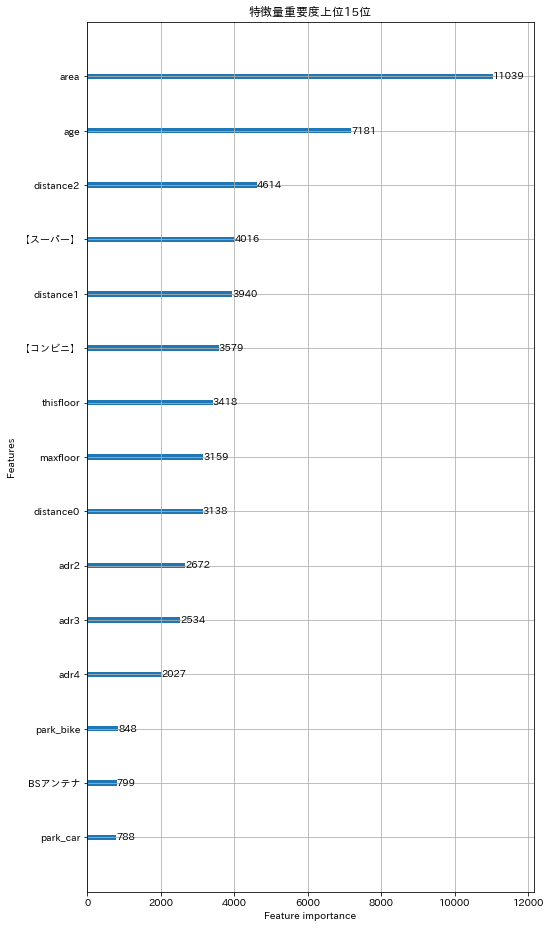

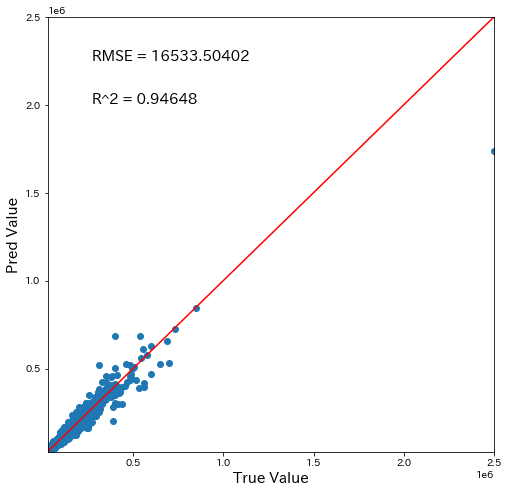

In [45]:
# conda install -c conda-forge lightgbm
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#関数の処理で必要なライブラリ
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# pip install optuna
from optuna.integration import lightgbm_tuner

#予測値と正解値を描写する関数
def True_Pred_map(pred_df):
    RMSE = np.sqrt(mean_squared_error(pred_df['true'], pred_df['pred']))
    R2 = r2_score(pred_df['true'], pred_df['pred'])
    plt.figure(figsize=(8,8))
    ax = plt.subplot(111)
    ax.scatter('true', 'pred', data=pred_df)
    ax.set_xlabel('True Value', fontsize=15)
    ax.set_ylabel('Pred Value', fontsize=15)
    ax.set_xlim(pred_df.min().min()-0.1 , pred_df.max().max()+0.1)
    ax.set_ylim(pred_df.min().min()-0.1 , pred_df.max().max()+0.1)
    x = np.linspace(pred_df.min().min()-0.1, pred_df.max().max()+0.1, 2)
    y = x
    ax.plot(x,y,'r-')
    plt.text(0.1, 0.9, 'RMSE = {}'.format(str(round(RMSE, 5))), transform=ax.transAxes, fontsize=15)
    plt.text(0.1, 0.8, 'R^2 = {}'.format(str(round(R2, 5))), transform=ax.transAxes, fontsize=15)





df_x = pd.read_csv('../../resource/Term2/train_processed.csv') # x:説明変数
df_test = pd.read_csv('../../resource/Term2/test_processed.csv')  # testデータ

df = pd.concat([df_x, df_test], axis=0)
# Object型のデータを全てダミー変数か
df = pd.get_dummies(df)

df_x = df[0:31470]
df_test = df[31470:]

df_y = df_x[['賃料']] # y:目的変数
df_x = df_x.drop('賃料', axis=1)
df_x = df_x.drop('id', axis=1)


# 訓練データとテストデータに分割する
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2)

# データセットを生成する
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# LightGBM のハイパーパラメータ
lgbm_params = {
    # 回帰問題
    'objective': 'regression',
    # RMSE (平均二乗誤差平方根) の最小化を目指す
    'metric': 'rmse',
}

'''
lgbm_params = {
    # 回帰問題
    'objective': 'regression',
    # RMSE (平均二乗誤差平方根) の最小化を目指す
    'metric': 'rmse',
    'max_depth': 100,
    'num_leaves': 100,
    'learning_rate': 0.1,
}
'''

'''
# Optuna でハイパーパラメータを Stepwise Optimization する
model = lightgbm_tuner.train(lgbm_params, lgb_train, 
                             valid_sets=lgb_eval,
                             num_boost_round = 100000,
                             early_stopping_rounds = 1000,
                             verbose_eval = 50,)
'''
# 上記のパラメータでモデルを学習する
model = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval,
                  num_boost_round = 100000,
                  early_stopping_rounds = 100,
                  verbose_eval = 50,)


# 特徴量重要度
lgb.plot_importance(model, height=0.1, figsize=(8,16),
                   max_num_features=15)
plt.title("特徴量重要度上位15位")
plt.savefig('figure.png', bbox_inches="tight")


# テストデータを予測する
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# RMSE を計算する
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(rmse)

# 可視化
pred_df = pd.concat([y_test.reset_index(drop=True), pd.Series(y_pred)], axis=1)
pred_df.columns = ['true', 'pred']
pred_df.head()
True_Pred_map(pred_df)


# sigante 提出用
df_id = df_test[['id']]
df_test = df_test.drop('賃料', axis=1)
df_test = df_test.drop('id', axis=1)
#print(len(df_id))
#print(df_test)

y_pred = model.predict(df_test, num_iteration=model.best_iteration)
y_pred = [int(n) for n in y_pred]
#print(len(y_pred))
df = pd.DataFrame(y_pred)

df = pd.concat([df_id, df], axis=1)
#print(df)
df.to_csv('submit.csv', index=None, header=None)

